# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker.pytorch import PyTorch

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-02-20 15:15:02--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.194.176
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.194.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  29.2MB/s    in 39s     

2023-02-20 15:15:43 (27.6 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

In [9]:
!aws s3 sync dogImages/ s3://dogimages/data/

upload: dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg to s3://dogimages/data/test/001.Affenpinscher/Affenpinscher_00047.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg to s3://dogimages/data/test/001.Affenpinscher/Affenpinscher_00003.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg to s3://dogimages/data/test/001.Affenpinscher/Affenpinscher_00058.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg to s3://dogimages/data/test/001.Affenpinscher/Affenpinscher_00048.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg to s3://dogimages/data/test/001.Affenpinscher/Affenpinscher_00023.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00141.jpg to s3://dogimages/data/test/002.Afghan_hound/Afghan_hound_00141.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00125.jpg to s3://dogimages/data/test/002.Afghan_hound/Afghan_hound_00125.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00116.jpg 

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [4]:
# General macros
session = sagemaker.Session()
bucket= "dogimages"
print("Default Bucket: {}".format(bucket))
region = session.boto_region_name
print("AWS Region: {}".format(region))
role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: dogimages
AWS Region: us-east-1
RoleArn: arn:aws:iam::219730617890:role/service-role/AmazonSageMaker-ExecutionRole-20230214T231475


In [ ]:
! python hpo.py

In [6]:
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [7]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    source_dir="scripts",
    entry_point="hpo.py",
    base_job_name='pytorch-dog-bread-classification-hpo',
    role=role,
    framework_version="1.8", # 1.4.0
    instance_count=1,
    instance_type="ml.m5.xlarge", #You can use GPU instance ml.p2.xlarge or standard instance ml.m5.large or local
    py_version='py36' # py3
)# TODO: Your estimator here

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=1,
    base_tuning_job_name = 'pytorch-dog-bread-classification-hpo-tuning',
    objective_type=objective_type
)# TODO: Your HP tuner here

In [20]:
# TODO: Fit your HP Tuner
tuner.fit({"training": f"s3://{bucket}/data/"}, wait=False)  # TODO: Remember to include your data channels

In [8]:
tuner = HyperparameterTuner.attach('pytorch-dog-bread-cl-230223-0959')

In [9]:
tuner.describe()

{'HyperParameterTuningJobName': 'pytorch-dog-bread-cl-230223-0959',
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:219730617890:hyper-parameter-tuning-job/pytorch-dog-bread-cl-230223-0959',
 'HyperParameterTuningJobConfig': {'Strategy': 'Bayesian',
  'HyperParameterTuningJobObjective': {'Type': 'Minimize',
   'MetricName': 'Test Loss'},
  'ResourceLimits': {'MaxNumberOfTrainingJobs': 4,
   'MaxParallelTrainingJobs': 1},
  'ParameterRanges': {'IntegerParameterRanges': [],
   'ContinuousParameterRanges': [{'Name': 'learning_rate',
     'MinValue': '0.001',
     'MaxValue': '0.1',
     'ScalingType': 'Auto'}],
   'CategoricalParameterRanges': [{'Name': 'batch_size',
     'Values': ['"32"', '"64"', '"128"', '"256"', '"512"']}]},
  'TrainingJobEarlyStoppingType': 'Off'},
 'TrainingJobDefinition': {'StaticHyperParameters': {'_tuning_objective_metric': 'Test Loss',
   'sagemaker_container_log_level': '20',
   'sagemaker_estimator_class_name': '"PyTorch"',
   'sagemaker_estimator_

In [10]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()#TODO

#Get the hyperparameters of the best trained model
best_estimeter_hpo = best_estimator.hyperparameters()

best_estimeter_hpo


2023-02-23 11:52:13 Starting - Found matching resource for reuse
2023-02-23 11:52:13 Downloading - Downloading input data
2023-02-23 11:52:13 Training - Training image download completed. Training in progress.
2023-02-23 11:52:13 Uploading - Uploading generated training model
2023-02-23 11:52:13 Completed - Resource reused by training job: pytorch-dog-bread-cl-230223-0959-004-80287f9b


{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'learning_rate': '0.0034098764227681443',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-dog-bread-classification-hpo-2023-02-23-09-59-52-278"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-219730617890/pytorch-dog-bread-classification-hpo-2023-02-23-09-59-52-278/source/sourcedir.tar.gz"'}

In [11]:
tuner.describe()['HyperParameterTuningJobName']

'pytorch-dog-bread-cl-230223-0959'

In [18]:
tuner.analytics().dataframe()

batch_size  learning_rate                                TrainingJobName  \
0       "32"       0.082138  pytorch-dog-bread-cl-230223-0959-004-80287f9b   
1       "32"       0.003410  pytorch-dog-bread-cl-230223-0959-003-dd687983   
2      "256"       0.063006  pytorch-dog-bread-cl-230223-0959-002-7d00d43e   
3       "32"       0.056468  pytorch-dog-bread-cl-230223-0959-001-c7be2a6f   

  TrainingJobStatus  FinalObjectiveValue         TrainingStartTime  \
0         Completed             4.901559 2023-02-23 11:52:15+00:00   
1         Completed             0.992286 2023-02-23 11:17:08+00:00   
2         Completed             4.868255 2023-02-23 10:35:16+00:00   
3         Completed             4.876931 2023-02-23 10:01:03+00:00   

            TrainingEndTime  TrainingElapsedTimeSeconds  
0 2023-02-23 12:25:15+00:00                      1980.0  
1 2023-02-23 11:49:48+00:00                      1960.0  
2 2023-02-23 11:12:32+00:00                      2236.0  
3 2023-02-23 10:34:36+00:00                      2013.0

In [14]:
# Best hyperparameters found:
hyperparameters = {"batch_size": int(best_estimeter_hpo['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimeter_hpo['learning_rate']}
hyperparameters

{'batch_size': 32, 'learning_rate': '0.0034098764227681443'}

In [15]:
hyperparameters['batch_size']

32

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [16]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
    ProfilerRule,
    ProfilerConfig,
    FrameworkProfile,
)

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]


debugger_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "213",
        "eval.save_interval": "31",
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

In [17]:
# TODO: Create and fit an estimator
#hyperparameters = {'batch_size': 32, 'learning_rate': '0.002885169972039605'}
hyperparameters = {"batch_size": int(best_estimeter_hpo['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimeter_hpo['learning_rate']}

estimator =  PyTorch( # TODO: Your estimator here
    source_dir="scripts",
    entry_point="train_model.py",
    base_job_name="pytorch-dog-bread-classification",
    role=role,
    instance_count=1,
    instance_type="ml.p2.xlarge", 
    framework_version='1.9',
    py_version='py38',
    hyperparameters=hyperparameters,
    output_path=f"s3://{bucket}/output/",
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules
)

estimator.fit({"training": f"s3://{bucket}/data/"}, wait=False)# TODO: Your estimator here

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-dog-bread-classification-2023-02-24-08-12-13-838


In [5]:
# If you restart your kernel attach your training job like this instead of re training.
estimator = PyTorch.attach("pytorch-dog-bread-classification-2023-02-24-07-39-50-031")


2023-02-24 07:57:58 Starting - Preparing the instances for training
2023-02-24 07:57:58 Downloading - Downloading input data
2023-02-24 07:57:58 Training - Training image download completed. Training in progress.
2023-02-24 07:57:58 Uploading - Uploading generated training model
2023-02-24 07:57:58 Completed - Training job completed


In [19]:
# Print training job information:
print("job name : {}\n".format(estimator.latest_training_job.job_name))
print("latest_job_debugger_artifacts_path : {}\n".format(estimator.latest_job_debugger_artifacts_path()))
print("rule_output_path : {}\n".format(estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"))

job name : pytorch-dog-bread-classification-2023-02-24-07-39-50-031

latest_job_debugger_artifacts_path : None

rule_output_path : s3://dogimages/output/pytorch-dog-bread-classification-2023-02-24-07-39-50-031/rule-output



In [22]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial("s3://dogimages/output/pytorch-dog-bread-classification-2023-02-24-07-39-50-031/debug-output/")

[2023-02-24 08:49:54.262 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO s3_trial.py:42] Loading trial  at path s3://dogimages/output/pytorch-dog-bread-classification-2023-02-24-07-39-50-031/debug-output/


In [21]:
trial.tensor_names()

[2023-02-24 08:46:29.601 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-02-24 08:46:30.626 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

INFO:matplotlib.font_manager:generated new fontManager


[2023-02-24 08:50:05.472 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-02-24 08:50:06.493 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:210] Loaded all steps
loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


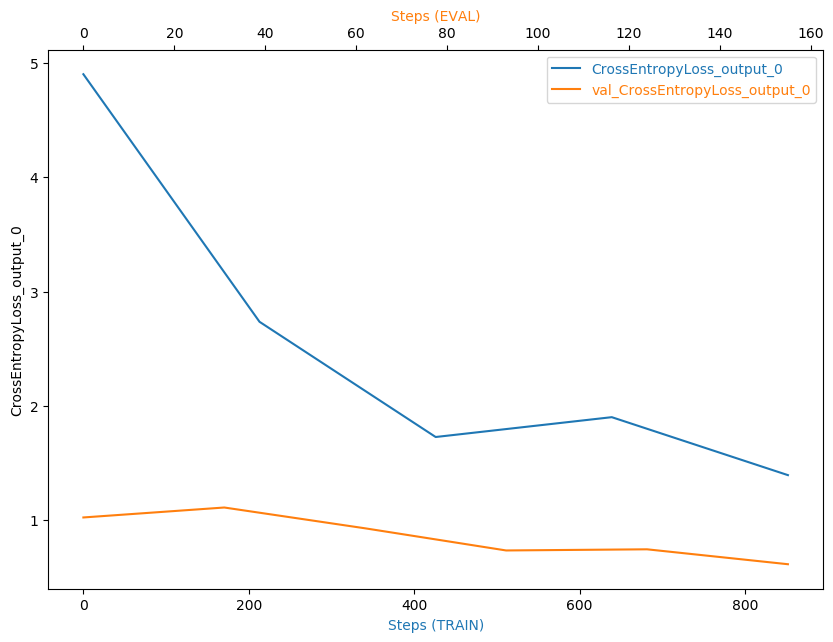

In [23]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    fig.savefig('training_debug_values.png')

plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

Learning curves are an essential tool for understanding how machine learning algorithms perform over time. By plotting the learning curves, one can gain insights into the training algorithm, including diagnosing underfitting and overfitting issues. 

Underfitting occurs when the validation score does not improve over time, suggesting that the model is not learning enough from the data. On the other hand, overfitting refers to a situation in which training curve keeps improving while the validation curve is getting worse. Both of these issues can be addressed by tuning the hyperparameters, or by collecting more data samples.

In [24]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [25]:
print(f"You will find the profiler report in {rule_output_path}")

! aws s3 cp {rule_output_path} ./ --recursive

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

You will find the profiler report in s3://dogimages/output/pytorch-dog-bread-classification-2023-02-24-07-39-50-031/rule-output
download: s3://dogimages/output/pytorch-dog-bread-classification-2023-02-24-07-39-50-031/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://dogimages/output/pytorch-dog-bread-classification-2023-02-24-07-39-50-031/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://dogimages/output/pytorch-dog-bread-classification-2023-02-24-07-39-50-031/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://dogimages/output/pytorch-dog-bread-classification-2023-02-24-07-39-50-031/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to Pr

## Model Deploying

In [ ]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

from PIL import Image
import io
import base64

In [11]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [12]:
model_location=estimator.model_data

pytorch_inference_model = PyTorchModel(
            entry_point="inference.py",
            source_dir="scripts",
            role=role,
            model_data=model_location,
            framework_version="1.9",
            py_version="py38",
            predictor_cls=ImagePredictor,
)

In [13]:
# TODO: Deploy your model to an endpoint

predictor = pytorch_inference_model.deploy(
    initial_instance_count=1, 
    instance_type='ml.m5.large',
) # TODO: Add your deployment configuration like instance type and number of instances

-------!

In [32]:
predictor.endpoint_name

'pytorch-inference-2023-02-24-08-55-05-979'

In [14]:
# Get the labels
from glob import glob
dog_names = [item[25:-1] for item in sorted(glob("dogImages/train/*/"))] # load list of dog names

In [15]:
# TODO: Run an prediction on the endpoint
import numpy as np
def prob(x):
    return np.exp(x) / np.sum(np.exp(x))

# with open("./dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg", "rb") as image:
#     f = image.read()
#     img_bytes = bytearray(f)

# Image.open(io.BytesIO(img_bytes))

def predict(path):
    #request_dict={ "url": url }
    with open(path, "rb") as image:
        f = image.read()
        img_bytes = bytearray(f)
        
    response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})
    display(Image.open(io.BytesIO(img_bytes)))
    logits = np.array(response[0])
    predicted_index = np.argmax(logits)
    print(f"Identified breed: {dog_names[predicted_index]}")
    print(f"Probability: {prob(logits)[predicted_index]}")

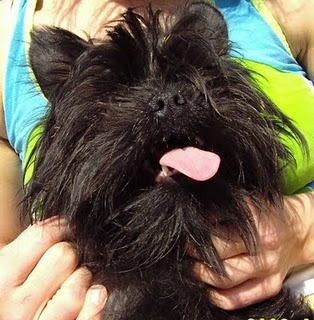

Identified breed: pinscher
Probability: 0.9947920669452683


In [16]:
predict("./dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg")

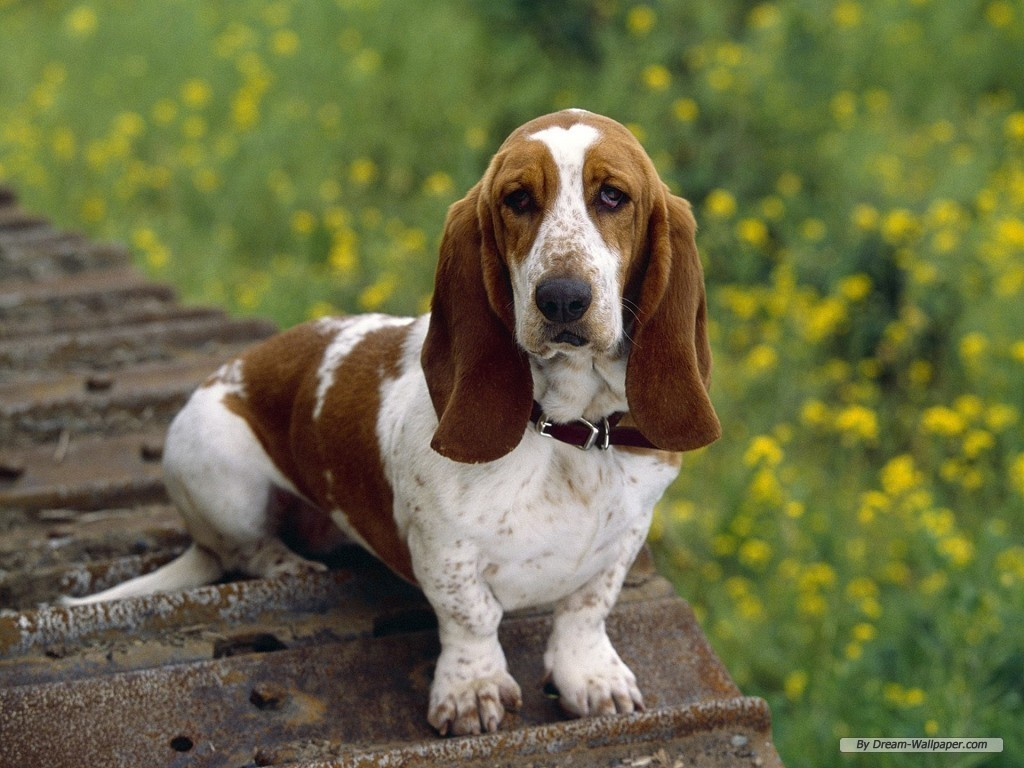

Identified breed: t_hound
Probability: 0.9963864790244484


In [44]:
predict("./dogImages/test/015.Basset_hound/Basset_hound_01044.jpg")

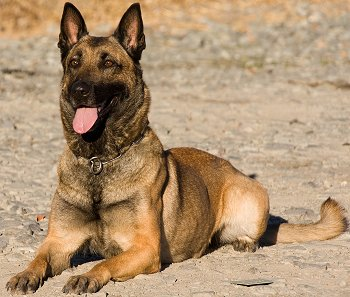

Identified breed: an_malinois
Probability: 0.9864320286313348


In [46]:
predict("./dogImages/test/020.Belgian_malinois/Belgian_malinois_01452.jpg")

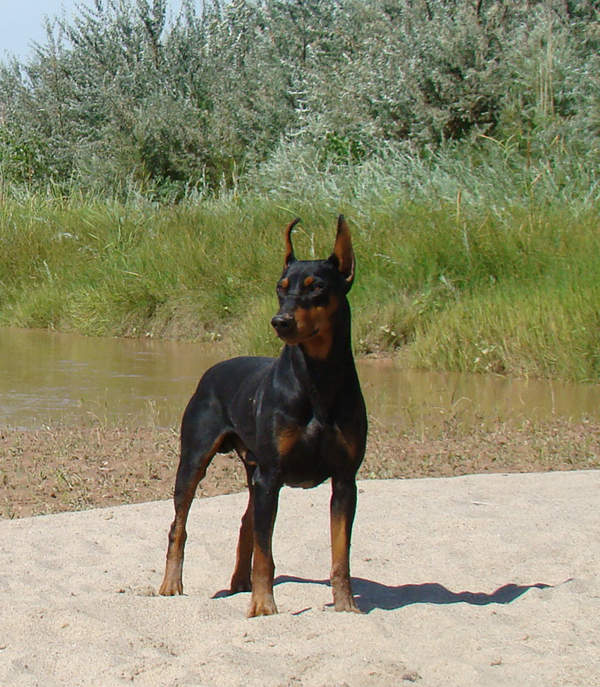

Identified breed: man_pinscher
Probability: 0.5654514539238189


In [47]:
predict("./dogImages/test/070.German_pinscher/German_pinscher_04843.jpg")

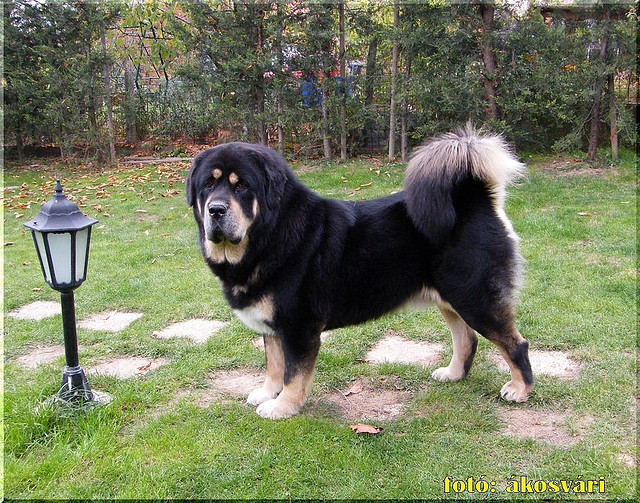

Identified breed: an_mastiff
Probability: 0.9955801026298237


In [48]:
predict("./dogImages/test/129.Tibetan_mastiff/Tibetan_mastiff_08140.jpg")

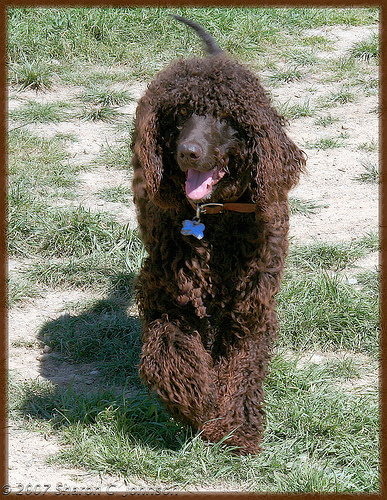

Identified breed: _water_spaniel
Probability: 0.9085961090339698


In [52]:
predict("./dogImages/test/088.Irish_water_spaniel/Irish_water_spaniel_05969.jpg")

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()